In [1]:
%matplotlib inline

In [70]:
import salvus.namespace as sn
from salvus.mesh import simple_mesh
from salvus.mesh.unstructured_mesh import UnstructuredMesh
from salvus.flow import api
import numpy as np
import os
from matplotlib import pyplot as plt


import sys
sys.path.append('./mass/')
from elemental_matrices import get_jacobian
from basis_polynomials import lagrange_basis_derivative_matrix
# +
TENSOR_ORDER = int(os.environ.get("TENSOR_ORDER", 4))
NUM_RANKS = int(os.environ.get("NUM_RANKS", 8))
INITIAL_VALUES = True if int(os.environ.get("INITIAL_VALUES", 0)) == 1 else False
PRECONDITIONER = False if int(os.environ.get("PRECONDITIONER", 0)) == 1 else True
MASS_SCALING = False if int(os.environ.get("PRECONDITIONER", 0)) == 1 else True

MASS_SCALING=False

mflag = "w/" if MASS_SCALING else "w/o"
pflag = "w/" if PRECONDITIONER else "w/o"
iflag = "w/" if INITIAL_VALUES else "w/o"

VERBOSITY = int(os.environ.get("VERBOSITY", 0))
TOTAL_VOLUME = 1
print(
    f"Running 2D Cartesian Poisson problem on {NUM_RANKS} rank(s):\n"
    f"- order {TENSOR_ORDER},\n"
    f"- {mflag} mass scaling,\n"
    f"- {pflag} preconditioner,\n"
    f"- {iflag} initial values."
)
G = 6.67408*10**-11
#M1 = 1/(4*np.pi*G)
M1 = 1

Running 2D Cartesian Poisson problem on 8 rank(s):
- order 4,
- w/o mass scaling,
- w/ preconditioner,
- w/o initial values.


In [141]:
def exact_solution(p):
    a = 10
    u_exact = (
        (2 ** (4 * a))
        * (p[:, :, 0] ** a)
        * (1 - p[:, :, 0]) ** a
        * (p[:, :, 1] ** a)
        * (1 - p[:, :, 1]) ** a
    )

    
    tol = 1e-8
    bmask_0 = p[:, :, 0] < tol
    bmask_1 = p[:, :, 1] < tol
    bmask_2 = p[:, :, 0] > 1 - tol
    bmask_3 = p[:, :, 1] > 1 - tol
    bmask = bmask_0 + bmask_1 + bmask_2 + bmask_3

#     assert np.max(np.abs(u_exact[bmask])) < tol
    u_exact[bmask] = 0.0
    

    return u_exact


def rhs_init_square(p):

    x = p[:, :, 0]
    y = p[:, :, 1]

    rhs = np.zeros_like(x)
    delta = 0.05
    mask = (x > 0.2 - delta) * (x < 0.2 + delta) * (y > 0.35 - delta) * (y < 0.35 + delta)
    rhs[mask] = 150.
    delta = 0.1
    mask = (x > 0.7 - delta) * (x < 0.7 + delta) * (y > 0.2 - delta) * (y < 0.2 + delta)
    rhs[mask] = 120.
    
    mask = (x > 0.6 - delta) * (x < 0.6 + delta) * (y > 0.7 - delta) * (y < 0.7 + delta)
    rhs[mask] = 80.
    
    return rhs

def rhs_init_uniform(p):
    
    x = p[:, :, 0]
    rhs = np.ones_like(x)*1
    
    return rhs


def forward_simulation(mesh, output_filename = "forward_simulation.h5", input_filename = "rhs_2d.h5"):
    w = sn.simple_config.simulation.Poisson(mesh=mesh)
    w.domain.polynomial_order = mesh.shape_order

    w.physics.poisson_equation.right_hand_side.filename = input_filename 
    w.physics.poisson_equation.right_hand_side.format = "hdf5"
    w.physics.poisson_equation.right_hand_side.field = "rhs"

    w.physics.poisson_equation.solution.filename = output_filename
    w.physics.poisson_equation.mass_matrix_scaling = MASS_SCALING

    boundaries = sn.simple_config.boundary.HomogeneousDirichlet(
        side_sets=["x0", "x1", "y0", "y1"]
    )

    # Associate boundaries with our simulation.
    w.add_boundary_conditions(boundaries)

    w.solver.max_iterations = 1000
    w.solver.absolute_tolerance = 0.0
    w.solver.relative_tolerance = 1e-10
    w.solver.preconditioner = PRECONDITIONER
    w.validate()
    # -

    api.run(
        input_file=w,
        site_name="local",
        output_folder="2d_simulation",
        overwrite=True,
        ranks=NUM_RANKS,
        verbosity=VERBOSITY,
    )

def adjoint_simulation(mesh):
    w = sn.simple_config.simulation.Poisson(mesh=mesh)
    w.domain.polynomial_order = mesh.shape_order

    w.physics.poisson_equation.right_hand_side.filename = "rhs_2d.h5"
    w.physics.poisson_equation.right_hand_side.format = "hdf5"
    w.physics.poisson_equation.right_hand_side.field = "rhs"

    w.physics.poisson_equation.solution.filename = "adjoint_state.h5"

    w.physics.poisson_equation.mass_matrix_scaling = MASS_SCALING

    boundaries = sn.simple_config.boundary.HomogeneousDirichlet(
        side_sets=["x0", "x1", "y0", "y1"]
    )


    # Associate boundaries with our simulation.
    w.add_boundary_conditions(boundaries)

    w.solver.max_iterations = 1000
    w.solver.absolute_tolerance = 0.0
    w.solver.relative_tolerance = 1e-8
    w.solver.preconditioner = PRECONDITIONER

    w.validate()
    # -

    api.run(
        input_file=w,
        site_name="local",
        output_folder="2d_simulation",
        overwrite=True,
        ranks=NUM_RANKS,
        verbosity=VERBOSITY,
    )
    
def new_mesh(rhs, output_filename="rhs_2d.h5"):
    m = simple_mesh.CartesianHomogeneousIsotropicElastic2D(
    vp=2.0, vs=1.0, rho=1.0, x_max=1.0, y_max=1.0, max_frequency=10.0)

    m.advanced.tensor_order = TENSOR_ORDER
    mesh = m.create_mesh()

    f = np.ones_like(mesh.elemental_fields["VP"])

    points = mesh.points[mesh.connectivity]

    mesh.elemental_fields = {}
    mesh.attach_field("M0", 1. * f)
    mesh.attach_field("M1", M1 * f)

    mesh.elemental_fields["fluid"] = np.ones([mesh.nelem])
    
    if rhs == 'init':
        rhs = rhs_init_uniform(points)
    else:
        rhs = rhs
        
    if rhs.shape != f.shape:
        rhs = rhs[mesh.connectivity]
    mesh.attach_field('fluid', np.ones(mesh.nelem))
    mesh.attach_field("rhs", rhs)
    mesh.write_h5(output_filename)
    return mesh

def new_mesh_obs(rhs, output_filename="rhs_obs.h5"):
    m = simple_mesh.CartesianHomogeneousIsotropicElastic2D(
    vp=2.0, vs=1.0, rho=1.0, x_max=1.0, y_max=1.0, max_frequency=10.0)

    m.advanced.tensor_order = TENSOR_ORDER
    mesh = m.create_mesh()

    f = np.ones_like(mesh.elemental_fields["VP"])

    points = mesh.points[mesh.connectivity]

    mesh.elemental_fields = {}
    mesh.attach_field("M0", 1.0 * f)
    mesh.attach_field("M1", M1  * f)

    mesh.elemental_fields["fluid"] = np.ones([mesh.nelem])
    
    rhs = rhs_init_square(points)
    
    if rhs.shape != f.shape:
        rhs = rhs[mesh.connectivity]
    mesh.attach_field('fluid', np.ones(mesh.nelem))
    mesh.attach_field("rhs", rhs)
    mesh.write_h5(output_filename)
    return mesh

def steplength(V, gradPsy, M, d_obs):
    c = 0.5 * np.linalg.norm(V)
    b = np.linalg.norm(gradPsy)
    
    output_filename="sigma_test"
    sigmatest = 10**2 #10**3 #1./np.mean(gradPsy)*10**1 #10**30
    rhs = np.array(M + sigmatest*gradPsy, dtype=np.float32)
    mesh_test = new_mesh(rhs)
    forward_simulation(mesh_test, output_filename)
    sol = UnstructuredMesh.from_h5('2d_simulation/' + output_filename)
    U = sol.element_nodal_fields['solution']
    psytest = 0.5 * np.linalg.norm(U - d_obs)
    
    a = sigmatest**(-2) * (psytest - b*sigmatest - c) #???
     
    return (-0.5) * b / a

def dll(dl,l, nx, ny):
    #param: nx and ny are the coordinates of the nodal point in the local c.s.
    #return: 
    n = dl.shape[0]
    l_local = np.zeros(n**2)
    for j in range(n):
        for i in range(n):
            k = j*5 + i
            l_local[k] = dl[nx, i]*l[ny, j]
    return l_local

def gradient(mesh, field='rhs', order = 4, ndim=2):
    from basis_polynomials import lagrange_basis_derivative_matrix,  lagrange_basis_polynomials
    from quadrature_points_weights import gauss_lobatto_legendre_quadruature_points_weights, gauss_quadruature_points_weights
    assert(field in mesh.element_nodal_fields.keys())
    
    points = gauss_lobatto_legendre_quadruature_points_weights(order+1)[0]
    n = len(points)
    J = get_jacobian(mesh)
    l = np.identity(n)
    dl = lagrange_basis_derivative_matrix(points)

    result = np.zeros((mesh.nelem, n**2, 2))
    
    for nelem in range(mesh.nelem):
        derivative_u_local = np.zeros((n**2, ndim))
        uarr = mesh.element_nodal_fields[field][nelem]
        for j in np.arange(n):
            for i in np.arange(n):
                k = j*n + i
                derivative_u_local[k,0] = np.sum(uarr * dll(dl, l, i, j))
                derivative_u_local[k,1] = np.sum(uarr * dll(l, dl, i, j))
        for i in range(n**2):
            result[nelem,i] = np.linalg.inv(J[nelem,i]).dot(derivative_u_local[i])
        mesh.attach_field('grad_x', result[:,:,0])
        mesh.attach_field('grad_y', result[:,:,1])
    return result

J 2733.85620868 rel J 1.0 0


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.0197101775919 503.236439024 1.0


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 487.91265424 rel J 0.178470488935 1


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


-0.0055040945136 501.765314805 10.9188795839


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 254.133938512 rel J 0.0929580486732 2


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.00181199259404 498.653644887 8.15711586755


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 205.082661904 rel J 0.0750158919305 3


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


-0.00029327207483 497.120159741 9.06067257908


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 179.599265678 rel J 0.0656944813367 4


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.000281830742479 497.059302757 8.91488111839


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in true_divide


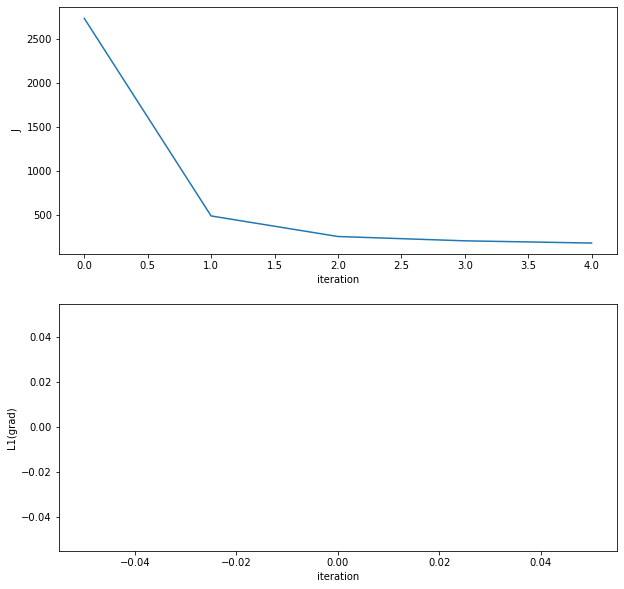

In [125]:
gradient_reg = False

mesh_f = new_mesh('init')
forward_simulation(mesh_f)

mesh_i = mesh_f.copy()
sol_i = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")

#d_obs:
mesh_obs = new_mesh_obs('init')
forward_simulation(mesh_obs, output_filename='obs.h5', input_filename='rhs_obs.h5')
sol_obs = UnstructuredMesh.from_h5("2d_simulation/obs.h5")
d_obs = sol_obs.element_nodal_fields['solution']
mesh_obs.write_h5('init.h5')

#nodal points array raveled
D = d_obs.ravel()
N_d_nodes = D.shape[0]

#Picking the meaningful observational points. A maps N_d_nodes -> N_d_obs
N_d_obs = N_d_nodes
A = np.zeros((N_d_obs, N_d_nodes))
if N_d_obs == N_d_nodes:
    A = np.identity(N_d_nodes) 
P = np.identity(N_d_obs)



J_arr = []
grad_arr = []
#Inverse problem:
for i in range(5):
    #  0. Solution vector (U):
    #sol = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")
    U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
    
    #  1. Vector of the discrepancy of the solution U from the observed data (V)
    V = d_obs - U
    
    alpha = 0.    #10**-3 #0.01
    beta  = 0.    #10**9 #1.
    if gradient_reg:
        
        # gradient L1 norm:
        mesh_f.attach_field('U', U)
        grad = gradient(mesh_f, field='U')
        grad_arr.append(np.sum(grad))
        
        # misfit:
        #J = np.linalg.norm(V) + alpha * np.linalg.norm(U) + beta * np.sum(grad)
        J = A.dot(D).T.dot(P).dot(A).dot(D)
        J_arr.append(J)
        V = d_obs - U + alpha * np.linalg.norm(U) + beta * np.sum(grad)
        
        print('J', J,'rel J', J/J_arr[0] , 'L1(grad)', np.sum(grad), i)
    
    else:
        # misfit:
        #J = np.linalg.norm(d_obs - U) + alpha * np.linalg.norm(U) 
        J = A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())
        J_arr.append(J)
        V = d_obs - U + alpha * np.linalg.norm(U) 
        
        print('J', J,'rel J', J/J_arr[0], i)
        
        
        
    #  2. Finding adjoint state vector (Z)
    
    mesh_a = new_mesh(V)
    adjoint_simulation(mesh_a)
    adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']

    #   3. Finding gradient of PSY

    Z = np.zeros_like(mesh_a.points[:,0])
    M = np.zeros_like(mesh_a.points[:,0])
    gradPsy = np.zeros_like(mesh_a.points[:,0])
    
    Z[mesh_a.connectivity] = adjoint
    M[mesh_a.connectivity] = mesh_f.elemental_fields['rhs']

    gradPsy = 1./M1 * Z #- np.ones_like(M)

    #  4. Update model:
    sigma = steplength(V, gradPsy, M, d_obs)
    print(np.mean(gradPsy), sigma, np.mean(M))
    M += sigma * gradPsy
    
    #  4.5 force density to be non-negative
    #M[M < 0.] = 0.
    #mesh_i.attach_field(f'iter{i}', M[mesh_a.connectivity])
    
    #  5. New forward simulation
    mesh_f = new_mesh(M[mesh_a.connectivity])
    forward_simulation(mesh_f)

sol = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")
final_U = sol.element_nodal_fields['solution']
mesh_f.attach_field('difference', abs(mesh_f.elemental_fields['rhs'] - mesh_obs.elemental_fields['rhs'])/mesh_obs.elemental_fields['rhs'])
mesh_f.attach_field('init_m', mesh_obs.elemental_fields['rhs'])

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10,10))
ax1.plot(J_arr)
ax1.set_xlabel('iteration')
ax1.set_ylabel('J')

ax2.plot(grad_arr)
ax2.set_xlabel('iteration')
ax2.set_ylabel('L1(grad)')

mesh_f.write_h5('test.h5')

In [ ]:
mesh_f = new_mesh('init')
forward_simulation(mesh_f)

mesh_i = mesh_f.copy()
sol_i = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")

#d_obs:
mesh_obs = new_mesh_obs('init')
forward_simulation(mesh_obs, output_filename='obs.h5', input_filename='rhs_obs.h5')
d_obs = UnstructuredMesh.from_h5("2d_simulation/obs.h5").element_nodal_fields['solution']
mesh_obs.write_h5('m0.h5')

#nodal points array raveled
D = d_obs.ravel()
N_d_nodes = D.shape[0]

#Picking the meaningful observational points. A maps N_d_nodes -> N_d_obs
N_d_obs = N_d_nodes
A = np.zeros((N_d_obs, N_d_nodes))
if N_d_obs == N_d_nodes:
    A = np.identity(N_d_nodes) 
P = np.identity(N_d_obs)

J_arr = []
grad_arr = []

#Inverse problem (conjugate gradient from Fichtner 2011):
#zeroth step:
U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
V = d_obs - U
J = A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())
J_arr.append(J)
print('J', J,'rel J', J/J_arr[0], i)

mesh_a = new_mesh(V)
adjoint_simulation(mesh_a)
adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']

Z = np.zeros_like(mesh_a.points[:,0])
M = np.zeros_like(mesh_a.points[:,0])
Z[mesh_a.connectivity] = adjoint

gradJ = 1./M1 * Z
h_prev = gradJ
gradJ_norm_prev = np.linalg.norm(gradJ)

niter = 30

for i in range(niter):
    #find the optimal steplength sigma:
    sigma = steplength(V, h_prev, M, d_obs)
    
    #update model:
    M[mesh_a.connectivity] = mesh_f.elemental_fields['rhs']
    M += sigma * h_prev
    print('gradJ:',np.mean(gradJ), sigma, np.mean(M))
    #mesh_f.elemental_fields['rhs'] += (sigma * h_prev)[mesh_f.connectivity]
    
    #new forward simulation
    mesh_f = new_mesh(M[mesh_f.connectivity])
    forward_simulation(mesh_f)
    
    #find new model gradient:
    U = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5").element_nodal_fields['solution']
    V = d_obs - U
    J = A.dot((d_obs - U).ravel()).T.dot(P).dot(A).dot((d_obs - U).ravel())
    J_arr.append(J)
    print('J', J,'rel J', J/J_arr[0], i)
    
    mesh_a = new_mesh(V)
    adjoint_simulation(mesh_a)
    adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']
    
    Z = np.zeros_like(mesh_a.points[:,0])
    M = np.zeros_like(mesh_a.points[:,0])
    Z[mesh_a.connectivity] = adjoint
    
    gradJ = 1./M1 * Z
    gradJ_norm_new = np.linalg.norm(gradJ)
    h_new = gradJ
    
    #find new direction:
    h_new = (1) * gradJ + gradJ_norm_prev / gradJ_norm_new * h_prev
    print(gradJ_norm_prev / gradJ_norm_new)
    gradJ_norm_prev = gradJ_norm_new
    h_prev = h_new

sol = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")
final_U = sol.element_nodal_fields['solution']
mesh_f.attach_field('difference', abs(mesh_f.elemental_fields['rhs'] - mesh_obs.elemental_fields['rhs'])/mesh_obs.elemental_fields['rhs'])
mesh_f.attach_field('init_m', mesh_obs.elemental_fields['rhs'])
mesh_f.write_h5('test.h5')

# fig, [ax1,ax2] = plt.subplots(2,1,figsize=(10,10))
# ax1.plot(J_arr)
# ax1.set_xlabel('iteration')
# ax1.set_ylabel('J')

# ax2.plot(grad_arr)
# ax2.set_xlabel('iteration')
# ax2.set_ylabel('L1(grad)')

print('finished')

J 2733.85620868 rel J 1.0 19


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: 0.0197101775919 49.031008304 1.96640988118


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 2165.71610713 rel J 0.7921836197 0


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1.14206246739


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: 0.0172535167756 49.173894559 3.92174935519


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 1246.52940171 rel J 0.455960118808 1


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1.40128835828


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: 0.0122857709246 49.4480553427 7.28452765567


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 385.451477874 rel J 0.140991862209 2


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


3.02841770071


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: 0.0037499624097 50.7385448049 17.9244707604


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 3652.01659655 rel J 1.33584809068 3


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.172727519414


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: -0.0232395001888 47.9381187467 18.5467890276


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 4097.89272657 rel J 1.49894230485 4


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.939395940369


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: -0.0247643364772 49.9807842893 17.9185615384


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 3569.43333259 rel J 1.30564048002 5


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1.07359710116


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: -0.0230602182436 51.2537670646 16.0449970701


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 2273.11383375 rel J 0.831467955973 6


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1.26935894326


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: -0.0181297634022 51.8674082896 12.6979538522


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 729.546278613 rel J 0.266856126631 7


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1.9165264384


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: -0.00936247549714 52.1195974884 5.76409910485


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 604.303851969 rel J 0.221044490215 8


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1.10070547908


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: 0.0087938321537 52.139498945 -1.4124410737


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 4848.92818423 rel J 1.77365882259 9


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.315637150862


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: 0.0276268242682 49.5446124328 -2.19612951076


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 5618.18894856 rel J 2.05504186019 10


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.927310022265


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


gradJ: 0.0297766151912 46.1068028421 -1.49952121318


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 5024.24874778 rel J 1.8377882245 11


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [137]:
np.max((test - h_prev))

0.0033351434553424986

In [139]:
np.max(test)

0.0025327043624610713

In [45]:
for i in range(100):
    #  0. Solution vector (U):
    sol = UnstructuredMesh.from_h5("2d_simulation/forward_simulation.h5")
    U = sol.element_nodal_fields['solution']

    #  1. Vector of the discrepancy of the solution U from the observed data (V)
    V = d_obs - U
    
    alpha = 0.015
    beta  = 1.
    if gradient_reg:
        # gradient L1 norm:
        mesh_f.attach_field('U', U)
        grad = gradient(mesh_f, field='U')
        # misfit:

        J = np.linalg.norm(V) + alpha * np.linalg.norm(U) + beta* np.sum(grad**1)
        J_arr.append(J)
        grad_arr.append(np.sum(grad**1))
        V = d_obs - U + alpha * np.linalg.norm(U) + beta* np.sum(grad**1)
        print('J', J,'rel J', J/J_arr[0] , 'L1(grad)', np.sum(grad**1), i)
    else:
        # misfit:
        alpha = 0.01
        J = np.linalg.norm(d_obs - U) + alpha * np.linalg.norm(U) 
        J_arr.append(J)
        print('J', J,'rel J', J/J_arr[0], i)
        V = d_obs - U + alpha * np.linalg.norm(U) 
        
    #  2. Finding adjoint state vector (Z)
    mesh_a = new_mesh(V)
    adjoint_simulation(mesh_a)

    adjoint = UnstructuredMesh.from_h5("2d_simulation/adjoint_state.h5").element_nodal_fields['solution']

    #   3. Finding gradient of PSY

    Z = np.zeros_like(mesh_a.points[:,0])
    M = np.zeros_like(mesh_a.points[:,0])
    gradPsy = np.zeros_like(mesh_a.points[:,0])

    Z[mesh_a.connectivity] = adjoint
    M[mesh_a.connectivity] = mesh_f.elemental_fields['rhs']

    #for i in range(len(M)):
        #gradPsy[i] = (-1) * Z[i] * (M[i] + delta_m)
    gradPsy = Z#/np.linalg.norm(Z)
    #  4. Update model:
    sigma = steplength(V, gradPsy, M, d_obs)
    M += sigma * gradPsy
   # M[M < 0.] = 0.
    #mesh_i.attach_field(f'iter{i}', M[mesh_a.connectivity])
    #  5. New forward simulation
    mesh_f = new_mesh(M[mesh_a.connectivity])
    forward_simulation(mesh_f)

J 1.14044214011e-05 rel J 514554.745593 0


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J 1.23860167102e-05 rel J 558843.228699 1


/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


--------------------
The following exception happened while running the job:


Traceback (most recent call last):
  File "salvus/flow/api.py", line 545, in salvus.flow.api.run
  File "salvus/flow/sites/job.py", line 399, in salvus.flow.sites.job.Job.wait
  File "salvus/flow/sites/salvus_job.py", line 853, in salvus.flow.sites.salvus_job.SalvusJob.update_status
  File "salvus/flow/sites/salvus_job.py", line 692, in salvus.flow.sites.salvus_job.SalvusJob.__check_meta_json
KeyboardInterrupt


--------------------
Please hang on - cancelling job ...


ValueError: Job with status `finished` cannot be cancelled.

In [442]:
mesh_f.write_h5('test.h5')

****31 august:::****

In [356]:
gradient(mesh_f)
mesh_f.write_h5('test.h5')

In [354]:
#different rhs fields for gradient fucntions tests
RHS = np.zeros_like(mesh_f.element_nodal_fields['rhs'])
coords = mesh_f.points[mesh_f.connectivity]
for i in range(RHS.shape[0]):
    for j in range(RHS.shape[1]):
#         RHS[i,j]=abs((coords[i,j,0]-0.5))**3 + abs((coords[i,j,1]-0.5)**3)
#        RHS[i,j] = 1 - (coords[i,j,0] - coords[i,j,1])**4
mesh_f.attach_field('rhs', RHS)